<H1>Cluster Analysis of Top 12 Virginia Craft Beer Locations</H1>

<H3>Import Libraries</H3>

In [2]:
from lxml import html
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
import folium
from bs4 import BeautifulSoup
import os
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

<H3>Scrape RateBeer Website for Brewery Count Data</H3> 

In [3]:
page = requests.get('https://www.ratebeer.com/breweries/virginia/46/213/')
tree = html.fromstring(page.content)

In [4]:
scrape = tree.xpath('//a[@href]/text()')

<H3>Wrangle Scraped Data</H3> 

In [5]:
scrape = scrape[22:534]

company = []
location = []

for i in scrape:
    if scrape.index(i)%2 == 0:
        company.append(i)
    else:
        location.append(i)

In [6]:
brew = pd.DataFrame({'company':company,'location':location})

<H4>Use value_counts() to get frequency data and limit to top 12 locations </H4>

In [7]:
dat = pd.DataFrame({'Freq':brew['location'].value_counts()})
dat = dat.head(12)
dat['Location'] = dat.index

<H4>Plot data using Matplotlib and Seaborn</H4> 

Text(0.5, 1.0, 'Top 12 Virginia Craft Beer Hotspots')

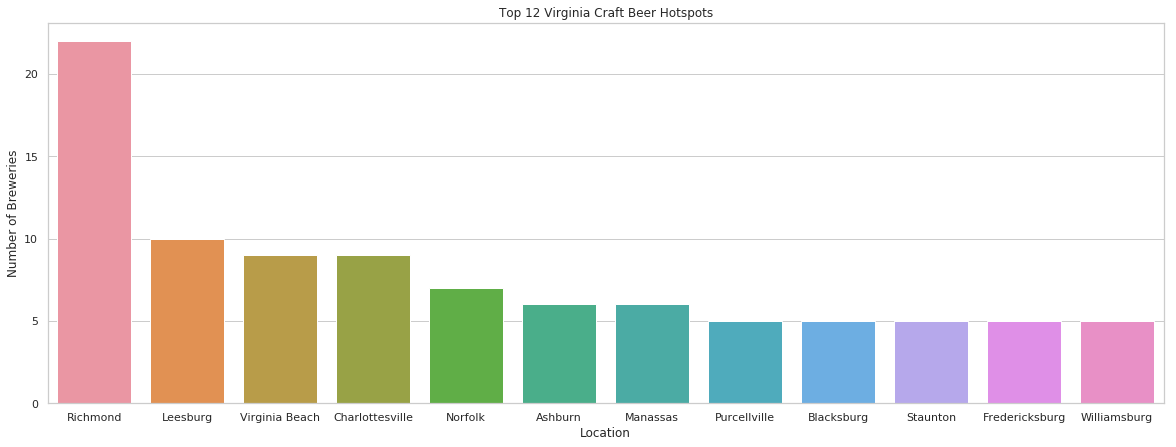

In [8]:
sns.set(style = "whitegrid")
fig_dims = (20, 7)
fig, ax = plt.subplots(figsize = fig_dims)
pl = sns.barplot(x = "Location" , y = "Freq", data = dat, ax = ax)
pl.set_ylabel('Number of Breweries')
pl.set_title('Top 12 Virginia Craft Beer Hotspots')

<H3>Get Geospatial Coordinates for the Top 12 Locations</H3>

In [9]:
places = list(dat['Location'])
Latitude = []
Longitude = []

for i in range(len(places)):
    address = '{}, Virginia, United States'.format(places[i])
    geolocator = Nominatim(user_agent = "Virginia_agent" )
    location = geolocator.geocode(address)
    Latitude.append(location.latitude)
    Longitude.append(location.longitude)
print(Latitude, Longitude)



[37.5385087, 39.1154496, 36.8529841, 38.029306, 36.8462923, 39.0437192, 38.7509488, 39.1367717, 37.2296566, 38.1495947, 38.2967927, 37.27892105] [-77.43428, -77.5645446, -75.9774183, -78.4766781, -76.2929252, -77.4874899, -77.4752667, -77.7147153, -80.4136767, -79.072557, -77.483409, -76.69448606443117]


<H4>Plot locations using Folium</H4> 

In [10]:
df = pd.DataFrame({"Locations":places,"Latitude":Latitude,"Longitude":Longitude})

In [11]:
map_va = folium.Map(location=[37.538509, -77.434280], zoom_start=8)


for lat, lng, place in zip(df['Latitude'], df['Longitude'], df['Locations']):
    label = '{}'.format(place)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_va)  
    
map_va

<H3>Retrieve Location Data</H3>

<H4>Foursquare Account Information</H4>

In [12]:
CLIENT_ID = '******************************************' # your Foursquare ID
CLIENT_SECRET = '*********************************************' # your Foursquare Secret
VERSION = '20200710'

<H4>Build a function for retrieving location data (this function gets the first 100 venues a given general category within a 2 mile radius of each location) </H4>

In [19]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=3218.69
    LIMIT=100
    categoryId = '4d4b7105d754a06374d81259'       #Arts & Entertainment = 4d4b7104d754a06370d81259  -  Outdoors & Rectreation = 4d4b7105d754a06377d81259  -  Food = 4d4b7105d754a06374d81259
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
    
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            categoryId)
            
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Location', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Arts & Entertainment Search 

In [15]:
virginia_venues_entertainment = getNearbyVenues(names=df['Locations'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Richmond
Leesburg
Virginia Beach
Charlottesville
Norfolk
Ashburn
Manassas
Purcellville
Blacksburg
Staunton
Fredericksburg
Williamsburg


Outdoor & Sports Recreation 

In [18]:
virginia_venues_nature = getNearbyVenues(names=df['Locations'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Richmond
Leesburg
Virginia Beach
Charlottesville
Norfolk
Ashburn
Manassas
Purcellville
Blacksburg
Staunton
Fredericksburg
Williamsburg


Restaurants 

In [20]:
virginia_venues_food = getNearbyVenues(names=df['Locations'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Richmond
Leesburg
Virginia Beach
Charlottesville
Norfolk
Ashburn
Manassas
Purcellville
Blacksburg
Staunton
Fredericksburg
Williamsburg


<H3>Prepare Location Data for k-means Cluster Analysis</H3>

<H4>One-hot encoding of venue category data for each general venue typing  </H4>

In [21]:
virginia_onehot_e = pd.get_dummies(virginia_venues_entertainment[['Venue Category']], prefix="", prefix_sep="")
virginia_onehot_e.insert(loc=0, column = "Location", value = virginia_venues_entertainment["Location"])
virginia_onehot_e.shape

(298, 27)

In [22]:
virginia_onehot_n = pd.get_dummies(virginia_venues_nature[['Venue Category']], prefix="", prefix_sep="")
virginia_onehot_n.insert(loc=0, column = "Location", value = virginia_venues_nature["Location"])
virginia_onehot_n.shape

(739, 60)

In [23]:
virginia_onehot_f = pd.get_dummies(virginia_venues_food[['Venue Category']], prefix="", prefix_sep="")
virginia_onehot_f.insert(loc=0, column = "Location", value = virginia_venues_food["Location"])
virginia_onehot_f.shape

(987, 73)

<H4>Make dataframes containing the mean coding values, grouped by location </H4>

In [24]:
virginia_grouped_e = virginia_onehot_e.groupby('Location').mean().reset_index()
virginia_grouped_e

,Location,Amphitheater,Art Gallery,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,Disc Golf,...,Music Venue,Opera House,Outdoor Sculpture,Performing Arts Venue,Piano Bar,Rock Club,Roller Rink,Science Museum,Theater,Tour Provider
0,Ashburn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,Blacksburg,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.00,0.153846,0.000000,...,0.076923,0.000000,0.000000,0.076923,0.000000,0.000000,0.0,0.000000,0.076923,0.000000
2,Charlottesville,0.030303,0.272727,0.030303,0.000000,0.000000,0.030303,0.00,0.090909,0.030303,...,0.212121,0.000000,0.000000,0.030303,0.000000,0.000000,0.0,0.030303,0.090909,0.000000
3,Fredericksburg,0.000000,0.173913,0.043478,0.043478,0.000000,0.043478,0.00,0.130435,0.043478,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.043478,0.043478
4,Leesburg,0.000000,0.200000,0.000000,0.100000,0.000000,0.000000,0.00,0.100000,0.000000,...,0.200000,0.000000,0.000000,0.100000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
5,Manassas,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.000000,...,0.166667,0.083333,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
6,Norfolk,0.000000,0.117647,0.019608,0.039216,0.019608,0.000000,0.00,0.078431,0.000000,...,0.098039,0.039216,0.019608,0.019608,0.019608,0.000000,0.0,0.019608,0.176471,0.000000
7,Purcellville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.200000,0.200000,...,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.2,0.000000,0.200000,0.000000
8,Richmond,0.000000,0.194030,0.014925,0.000000,0.014925,0.044776,0.00,0.059701,0.014925,...,0.208955,0.000000,0.014925,0.044776,0.000000,0.000000,0.0,0.000000,0.119403,0.059701
9,Staunton,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.00,0.076923,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.307692,0.000000


In [25]:
virginia_grouped_n = virginia_onehot_n.groupby('Location').mean().reset_index()
virginia_grouped_n

,Location,Athletics & Sports,Badminton Court,Baseball Field,Beach,Bowling Green,Boxing Gym,Climbing Gym,Cycle Studio,Dive Spot,...,Surf Spot,Tennis Court,Track,Trail,Tree,Vineyard,Volleyball Court,Waterfront,Weight Loss Center,Yoga Studio
0,Ashburn,0.107143,0.011905,0.047619,0.000000,0.000000,0.00,0.000000,0.00,0.00,...,0.011905,0.011905,0.011905,0.059524,0.000000,0.000000,0.000000,0.00,0.000000,0.071429
1,Blacksburg,0.065217,0.000000,0.021739,0.000000,0.000000,0.00,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.065217,0.021739,0.000000,0.000000,0.00,0.000000,0.021739
2,Charlottesville,0.011111,0.000000,0.033333,0.000000,0.000000,0.00,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.066667,0.044444,0.011111,0.011111,0.00,0.000000,0.122222
3,Fredericksburg,0.066667,0.000000,0.022222,0.000000,0.000000,0.00,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.044444,0.022222,0.000000,0.000000,0.00,0.044444,0.022222
4,Leesburg,0.061538,0.000000,0.015385,0.000000,0.000000,0.00,0.000000,0.00,0.00,...,0.000000,0.015385,0.000000,0.015385,0.000000,0.000000,0.000000,0.00,0.015385,0.015385
5,Manassas,0.080000,0.000000,0.020000,0.000000,0.000000,0.02,0.000000,0.02,0.02,...,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.00,0.020000,0.020000
6,Norfolk,0.034884,0.000000,0.000000,0.011628,0.000000,0.00,0.011628,0.00,0.00,...,0.000000,0.011628,0.000000,0.034884,0.000000,0.000000,0.000000,0.00,0.000000,0.058140
7,Purcellville,0.086957,0.000000,0.086957,0.000000,0.000000,0.00,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.043478,0.000000,0.000000,0.000000,0.00,0.000000,0.043478
8,Richmond,0.050000,0.000000,0.000000,0.020000,0.010000,0.00,0.000000,0.00,0.00,...,0.000000,0.000000,0.010000,0.050000,0.000000,0.000000,0.000000,0.00,0.000000,0.040000
9,Staunton,0.000000,0.000000,0.047619,0.000000,0.047619,0.00,0.000000,0.00,0.00,...,0.000000,0.000000,0.000000,0.095238,0.000000,0.000000,0.000000,0.00,0.000000,0.000000


In [26]:
virginia_grouped_f = virginia_onehot_f.groupby('Location').mean().reset_index()
virginia_grouped_f

,Location,African Restaurant,American Restaurant,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bistro,Brazilian Restaurant,Breakfast Spot,...,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Ashburn,0.000000,0.070000,0.020000,0.020000,0.010000,0.010000,0.000000,0.000000,0.010000,...,0.020000,0.040000,0.000000,0.000000,0.020000,0.050000,0.000000,0.000000,0.020000,0.010000
1,Blacksburg,0.000000,0.085714,0.014286,0.014286,0.014286,0.042857,0.000000,0.014286,0.014286,...,0.000000,0.028571,0.000000,0.000000,0.000000,0.028571,0.000000,0.014286,0.000000,0.028571
2,Charlottesville,0.011111,0.077778,0.000000,0.033333,0.022222,0.022222,0.011111,0.000000,0.033333,...,0.000000,0.000000,0.022222,0.011111,0.000000,0.022222,0.011111,0.000000,0.000000,0.000000
3,Fredericksburg,0.000000,0.100000,0.000000,0.030000,0.000000,0.030000,0.000000,0.000000,0.020000,...,0.020000,0.020000,0.000000,0.010000,0.020000,0.020000,0.000000,0.020000,0.010000,0.000000
4,Leesburg,0.000000,0.063830,0.000000,0.021277,0.000000,0.063830,0.000000,0.000000,0.021277,...,0.010638,0.000000,0.010638,0.000000,0.000000,0.010638,0.000000,0.000000,0.010638,0.010638
5,Manassas,0.000000,0.058824,0.000000,0.023529,0.000000,0.047059,0.000000,0.000000,0.023529,...,0.011765,0.011765,0.000000,0.000000,0.000000,0.023529,0.000000,0.000000,0.011765,0.035294
6,Norfolk,0.000000,0.086957,0.021739,0.000000,0.010870,0.032609,0.000000,0.010870,0.021739,...,0.010870,0.021739,0.010870,0.000000,0.000000,0.000000,0.000000,0.000000,0.010870,0.000000
7,Purcellville,0.000000,0.105263,0.052632,0.026316,0.000000,0.026316,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.026316
8,Richmond,0.000000,0.030928,0.020619,0.041237,0.010309,0.061856,0.010309,0.000000,0.030928,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.010309,0.000000,0.000000,0.000000,0.000000
9,Staunton,0.000000,0.098361,0.000000,0.016393,0.000000,0.016393,0.016393,0.000000,0.000000,...,0.016393,0.000000,0.000000,0.000000,0.016393,0.016393,0.000000,0.016393,0.000000,0.000000


<H4>Merge all 3 dataframes</H4>

In [27]:
virginia_grouped_n_drop = virginia_grouped_n.drop("Location", axis = 1)
virginia_grouped_f_drop = virginia_grouped_f.drop("Location", axis = 1)
virginia_grouped = pd.concat([virginia_grouped_e,virginia_grouped_n_drop,virginia_grouped_f_drop], axis = 1)
virginia_grouped

,Location,Amphitheater,Art Gallery,Art Museum,Arts & Entertainment,Comedy Club,Concert Hall,Country Dance Club,Dance Studio,Disc Golf,...,Steakhouse,Sushi Restaurant,Taco Place,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Ashburn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.250000,0.000000,...,0.020000,0.040000,0.000000,0.000000,0.020000,0.050000,0.000000,0.000000,0.020000,0.010000
1,Blacksburg,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.00,0.153846,0.000000,...,0.000000,0.028571,0.000000,0.000000,0.000000,0.028571,0.000000,0.014286,0.000000,0.028571
2,Charlottesville,0.030303,0.272727,0.030303,0.000000,0.000000,0.030303,0.00,0.090909,0.030303,...,0.000000,0.000000,0.022222,0.011111,0.000000,0.022222,0.011111,0.000000,0.000000,0.000000
3,Fredericksburg,0.000000,0.173913,0.043478,0.043478,0.000000,0.043478,0.00,0.130435,0.043478,...,0.020000,0.020000,0.000000,0.010000,0.020000,0.020000,0.000000,0.020000,0.010000,0.000000
4,Leesburg,0.000000,0.200000,0.000000,0.100000,0.000000,0.000000,0.00,0.100000,0.000000,...,0.010638,0.000000,0.010638,0.000000,0.000000,0.010638,0.000000,0.000000,0.010638,0.010638
5,Manassas,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.00,0.250000,0.000000,...,0.011765,0.011765,0.000000,0.000000,0.000000,0.023529,0.000000,0.000000,0.011765,0.035294
6,Norfolk,0.000000,0.117647,0.019608,0.039216,0.019608,0.000000,0.00,0.078431,0.000000,...,0.010870,0.021739,0.010870,0.000000,0.000000,0.000000,0.000000,0.000000,0.010870,0.000000
7,Purcellville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.200000,0.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000,0.000000,0.026316
8,Richmond,0.000000,0.194030,0.014925,0.000000,0.014925,0.044776,0.00,0.059701,0.014925,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.010309,0.000000,0.000000,0.000000,0.000000
9,Staunton,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.00,0.076923,0.000000,...,0.016393,0.000000,0.000000,0.000000,0.016393,0.016393,0.000000,0.016393,0.000000,0.000000


<H3>k-means Clustering of Locations by Venue Frequencies</H3>

<H4> Optimize k</H4>

In [29]:
virginia_grouped_clustering = virginia_grouped.drop('Location', 1)

Sum_of_Squares = []

for k in range(1,13):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(virginia_grouped_clustering)
    Sum_of_Squares.append(kmeans.inertia_)
    
Sum_of_Squares
    

[1.8561297783414334,
 1.3599822920725329,
 1.0077824930428547,
 0.7776979966089688,
 0.6229491592262182,
 0.4878282165395669,
 0.3433522663758644,
 0.2517640281060412,
 0.17536649204269641,
 0.10600236131968871,
 0.0459100596608704,
 0.0]

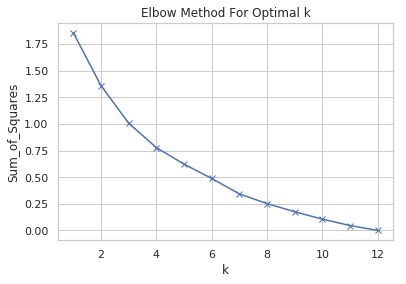

In [30]:
plt.plot(range(1,13), Sum_of_Squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_Squares')
plt.title('Elbow Method For Optimal k')
plt.show()

<H4>Run k-means cluster analysis (4 clusters) using virginia_grouped data</H4>

In [61]:
kclusters = 4

virginia_grouped_clustering = virginia_grouped.drop('Location', 1)


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(virginia_grouped_clustering)


kmeans.labels_[0:12]

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 3, 2], dtype=int32)

<H4> Create dataframes for the top 10 most frequent venue categories for each location, each dataframe is dedicated to a different general typing </H4>

In [50]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [51]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']


columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


location_venues_sorted = pd.DataFrame(columns=columns)
location_venues_sorted['Location'] = virginia_grouped_e['Location']

for ind in np.arange(virginia_grouped.shape[0]):
    location_venues_sorted.iloc[ind, 1:] = return_most_common_venues(virginia_grouped_e.iloc[ind, :], num_top_venues)

entertainment = location_venues_sorted

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']


columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


location_venues_sorted = pd.DataFrame(columns=columns)
location_venues_sorted['Location'] = virginia_grouped_n['Location']

for ind in np.arange(virginia_grouped.shape[0]):
    location_venues_sorted.iloc[ind, 1:] = return_most_common_venues(virginia_grouped_n.iloc[ind, :], num_top_venues)

nature = location_venues_sorted

In [53]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']


columns = ['Location']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


location_venues_sorted = pd.DataFrame(columns=columns)
location_venues_sorted['Location'] = virginia_grouped_f['Location']

for ind in np.arange(virginia_grouped.shape[0]):
    location_venues_sorted.iloc[ind, 1:] = return_most_common_venues(virginia_grouped_f.iloc[ind, :], num_top_venues)

food = location_venues_sorted

<H4>Add cluster labels and merge the location_venues_sorted and df dataframes</H4>

In [54]:
location_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

virginia_merged = df

virginia_merged = virginia_merged.join(location_venues_sorted.set_index('Location'), on='Locations')


<H4>Plot clusters using Folium</H4>

In [44]:
map_clusters = folium.Map(location=[37.538509, -77.434280], zoom_start=8)


x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


markers_colors = []
for lat, lng, place, cluster in zip(virginia_merged['Latitude'], virginia_merged['Longitude'], virginia_merged['Locations'], virginia_merged['Cluster Labels']):
    label = folium.Popup(str(place) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

<H3>Ten Most Frequent Venue Categories for Each Location</H3>

By Arts & Entertainment 

In [58]:
entertainment.insert(0, 'Cluster Labels', kmeans.labels_)
entertainment

,Cluster Labels,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Ashburn,Performing Arts Venue,Country Dance Club,Dance Studio,Movie Theater,Tour Provider,Memorial Site,Art Gallery,Art Museum,Arts & Entertainment,Comedy Club
1,1,Blacksburg,Museum,History Museum,Dance Studio,Art Gallery,Performing Arts Venue,Music Venue,Movie Theater,Theater,Indie Movie Theater,Tour Provider
2,1,Charlottesville,Art Gallery,Music Venue,Theater,Dance Studio,History Museum,Movie Theater,Amphitheater,Science Museum,Art Museum,Performing Arts Venue
3,1,Fredericksburg,History Museum,Art Gallery,Dance Studio,Museum,Tour Provider,Art Museum,Arts & Entertainment,Concert Hall,Disc Golf,Multiplex
4,1,Leesburg,Art Gallery,Music Venue,History Museum,Arts & Entertainment,Performing Arts Venue,Museum,Dance Studio,Tour Provider,Indie Movie Theater,Art Museum
5,1,Manassas,Dance Studio,Music Venue,Movie Theater,Mini Golf,Art Gallery,Opera House,Museum,History Museum,Indie Movie Theater,Art Museum
6,1,Norfolk,Theater,History Museum,Museum,Art Gallery,Music Venue,Dance Studio,Movie Theater,Opera House,Arts & Entertainment,Science Museum
7,0,Purcellville,Roller Rink,Performing Arts Venue,Dance Studio,Disc Golf,Theater,Tour Provider,Indie Movie Theater,Art Gallery,Art Museum,Arts & Entertainment
8,1,Richmond,Music Venue,Art Gallery,History Museum,Theater,Dance Studio,Tour Provider,Performing Arts Venue,Museum,Concert Hall,Outdoor Sculpture
9,1,Staunton,Theater,History Museum,Movie Theater,Mini Golf,Indie Movie Theater,Art Gallery,Dance Studio,Museum,Art Museum,Arts & Entertainment


By Outdoors & Recreation 

In [59]:
nature.insert(0, 'Cluster Labels', kmeans.labels_)
nature

,Cluster Labels,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Ashburn,Gym,Gym / Fitness Center,Athletics & Sports,Martial Arts Dojo,Park,Yoga Studio,Trail,Pool,Baseball Field,Playground
1,1,Blacksburg,Gym / Fitness Center,Gym,Park,Athletics & Sports,Trail,Plaza,Rugby Pitch,Golf Course,Baseball Field,Farm
2,1,Charlottesville,Gym / Fitness Center,Park,Yoga Studio,Trail,Gym,Tree,Plaza,Martial Arts Dojo,Baseball Field,Playground
3,1,Fredericksburg,Park,Martial Arts Dojo,Athletics & Sports,Soccer Field,Gym,Gym / Fitness Center,Plaza,Weight Loss Center,Trail,River
4,1,Leesburg,Park,Gym,Gym / Fitness Center,Martial Arts Dojo,Athletics & Sports,Playground,Plaza,Pool,Scenic Lookout,Baseball Field
5,1,Manassas,Gym,Gym / Fitness Center,Park,Athletics & Sports,Martial Arts Dojo,Skating Rink,Pool,Plaza,Playground,Weight Loss Center
6,1,Norfolk,Park,Gym,Gym / Fitness Center,Harbor / Marina,Yoga Studio,Trail,Athletics & Sports,Plaza,Dog Run,Pedestrian Plaza
7,0,Purcellville,Farm,Gym,Gym / Fitness Center,Athletics & Sports,Baseball Field,Nature Preserve,Skating Rink,Golf Course,Martial Arts Dojo,Park
8,1,Richmond,Park,Gym,Scenic Lookout,Gym / Fitness Center,Athletics & Sports,Trail,Pool,River,Yoga Studio,Gym Pool
9,1,Staunton,Park,Gym,Soccer Field,Trail,Gym / Fitness Center,Pedestrian Plaza,Lake,Gymnastics Gym,Recreation Center,Golf Course


By Restaurants and Other Food Venues 

In [60]:
food.insert(0, 'Cluster Labels', kmeans.labels_)
food

,Cluster Labels,Location,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Ashburn,Pizza Place,Sandwich Place,American Restaurant,Burger Joint,Thai Restaurant,Restaurant,Fast Food Restaurant,Indian Restaurant,Sushi Restaurant,Chinese Restaurant
1,1,Blacksburg,Sandwich Place,American Restaurant,Mexican Restaurant,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Italian Restaurant,Deli / Bodega,Bakery,Burger Joint
2,1,Charlottesville,Mexican Restaurant,American Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Chinese Restaurant,French Restaurant,Donut Shop,Café,BBQ Joint
3,1,Fredericksburg,American Restaurant,Italian Restaurant,Sandwich Place,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Chinese Restaurant,Seafood Restaurant,Bakery,Donut Shop
4,1,Leesburg,Pizza Place,Sandwich Place,Chinese Restaurant,Bakery,American Restaurant,Mexican Restaurant,Fast Food Restaurant,Latin American Restaurant,Italian Restaurant,Burger Joint
5,1,Manassas,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Sandwich Place,American Restaurant,Bakery,Food,Donut Shop,Wings Joint,Restaurant
6,1,Norfolk,Seafood Restaurant,American Restaurant,Pizza Place,Fast Food Restaurant,Italian Restaurant,Chinese Restaurant,Mexican Restaurant,Sandwich Place,Café,Bakery
7,0,Purcellville,Mexican Restaurant,Pizza Place,American Restaurant,Fast Food Restaurant,Asian Restaurant,Restaurant,Sandwich Place,Café,Donut Shop,Diner
8,1,Richmond,Seafood Restaurant,Bakery,Sandwich Place,Deli / Bodega,Café,New American Restaurant,Italian Restaurant,Pizza Place,French Restaurant,Southern / Soul Food Restaurant
9,1,Staunton,Fast Food Restaurant,Sandwich Place,Italian Restaurant,Pizza Place,American Restaurant,Japanese Restaurant,Mexican Restaurant,Donut Shop,Diner,Mediterranean Restaurant
